In [1]:
from training import *
from analysis import *
def plot_input_histogram_to_parallel_synapse_layer(model, 
                                                testloader, 
                                                hidden_act:str = 'sigmoid', 
                                                is_normalized = False,
                                                file_name: str = '') -> None:
    '''
    plot histograms of hidden layer input and final layer input
    
    Inputs:
        model: nn.Module
    '''
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, model.fc1.weight.shape[-1])#.to(device)
        
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs) + 10).detach().cpu())
        else:
            hidden.append(torch.relu(model.fc1(inputs) + 10).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
        
    hidden_thres = 1e-4
    hidden = torch.cat(hidden, dim=0)
    
    hidden = hidden.data.cpu().numpy()
    final = torch.cat(final, dim=0)
    plt.figure(figsize=(9, 3 ))
    plt.subplot(1,3,1)
    plt.hist(hidden[hidden>hidden_thres].flatten(), bins=100)
    plt.title('Hidden activation, {:.1f}% > {:.2E}'.format((hidden>hidden_thres).mean() * 100, hidden_thres))
    # plt.legend()
    plt.xlabel('hidden layer input')
    plt.ylabel('count')
    
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    input = torch.cat([torch.linspace(0,  hidden[:, i].max(), steps = n_data).reshape(-1, 1) for i in np.arange(hidden.shape[1])], dim = 1)

    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    

    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * (input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
        - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim))
    x = torch.tanh(x)
    x = x * (ampli[None, :, :, :]**2 ).expand(n_data, n_synapse, input_dim, output_dim)
    x = x * torch.abs(f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim))
    x = x.sum(dim=1).squeeze() 
    # if is_normalized:

    #     input = input * hidden.max(dim = 0)
    
    plt.subplot(1,3,2)
    plt.hist(final.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    ylim = plt.ylim()
    plt.legend()
    plt.xlabel('output')
    plt.title('Histogram, final layer input')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize = (10, 8), dpi=300)
    
    for i in np.arange(min([20, input_dim])):
        plt.subplot(4,5,i+1)
        plt.plot( torch.linspace(0, 1, steps=n_data), x.detach().numpy()[:,i,:], alpha = 1)
        # plt.title(str(i+1) + '-th hidden -> output')
        plt.title('Hidden unit ' + str(i+1))
        plt.xlabel('Input (percentile)')
    plt.tight_layout()
    plt.savefig(file_name + '_grouped_by_hidden.png')
    plt.show()
    
    
    plt.figure(figsize = (10, 8), dpi=300)
    
    for i in np.arange(min([10, output_dim])):
        plt.subplot(4,5,i+1)
        plt.plot( torch.linspace(0, 1, steps=n_data), x.detach().numpy()[:,:,i], alpha = 1, lw = 1)
        plt.title('Output unit ' + str(i+1))
        plt.xlabel('Input (percentile)')
    plt.tight_layout()
    plt.savefig(file_name + '_grouped_by_output.pdf')
    plt.show()
    return hidden

input_dim, hidden_dim, n_synapse, output_dim = 28*28, 20, 5, 10
bias = 10
hidden_range = (0, 10)

model = ParallelSynapse2NN(input_dim=input_dim,
                hidden_dim = hidden_dim, 
                n_synapse = n_synapse,
                hidden_range = hidden_range, 
                additive_bias = bias)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

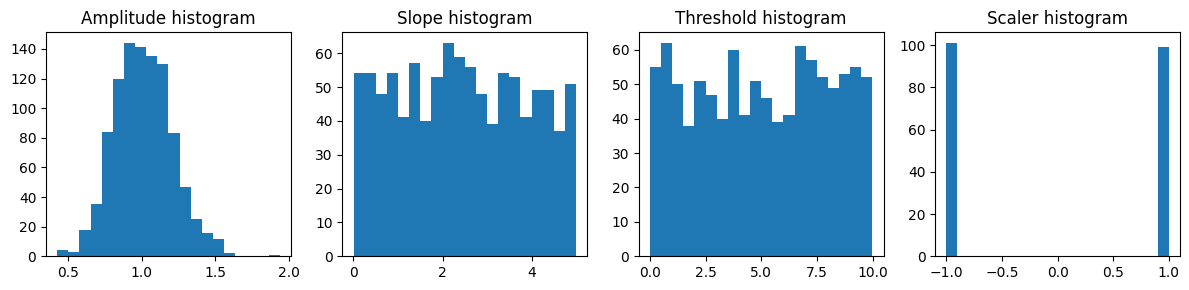

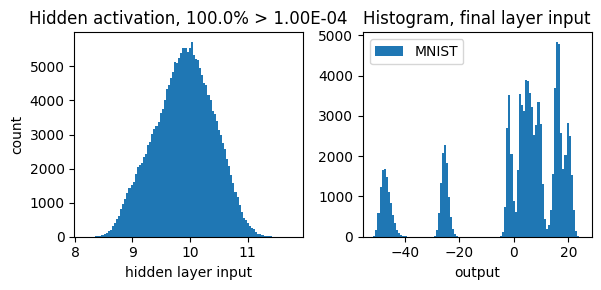

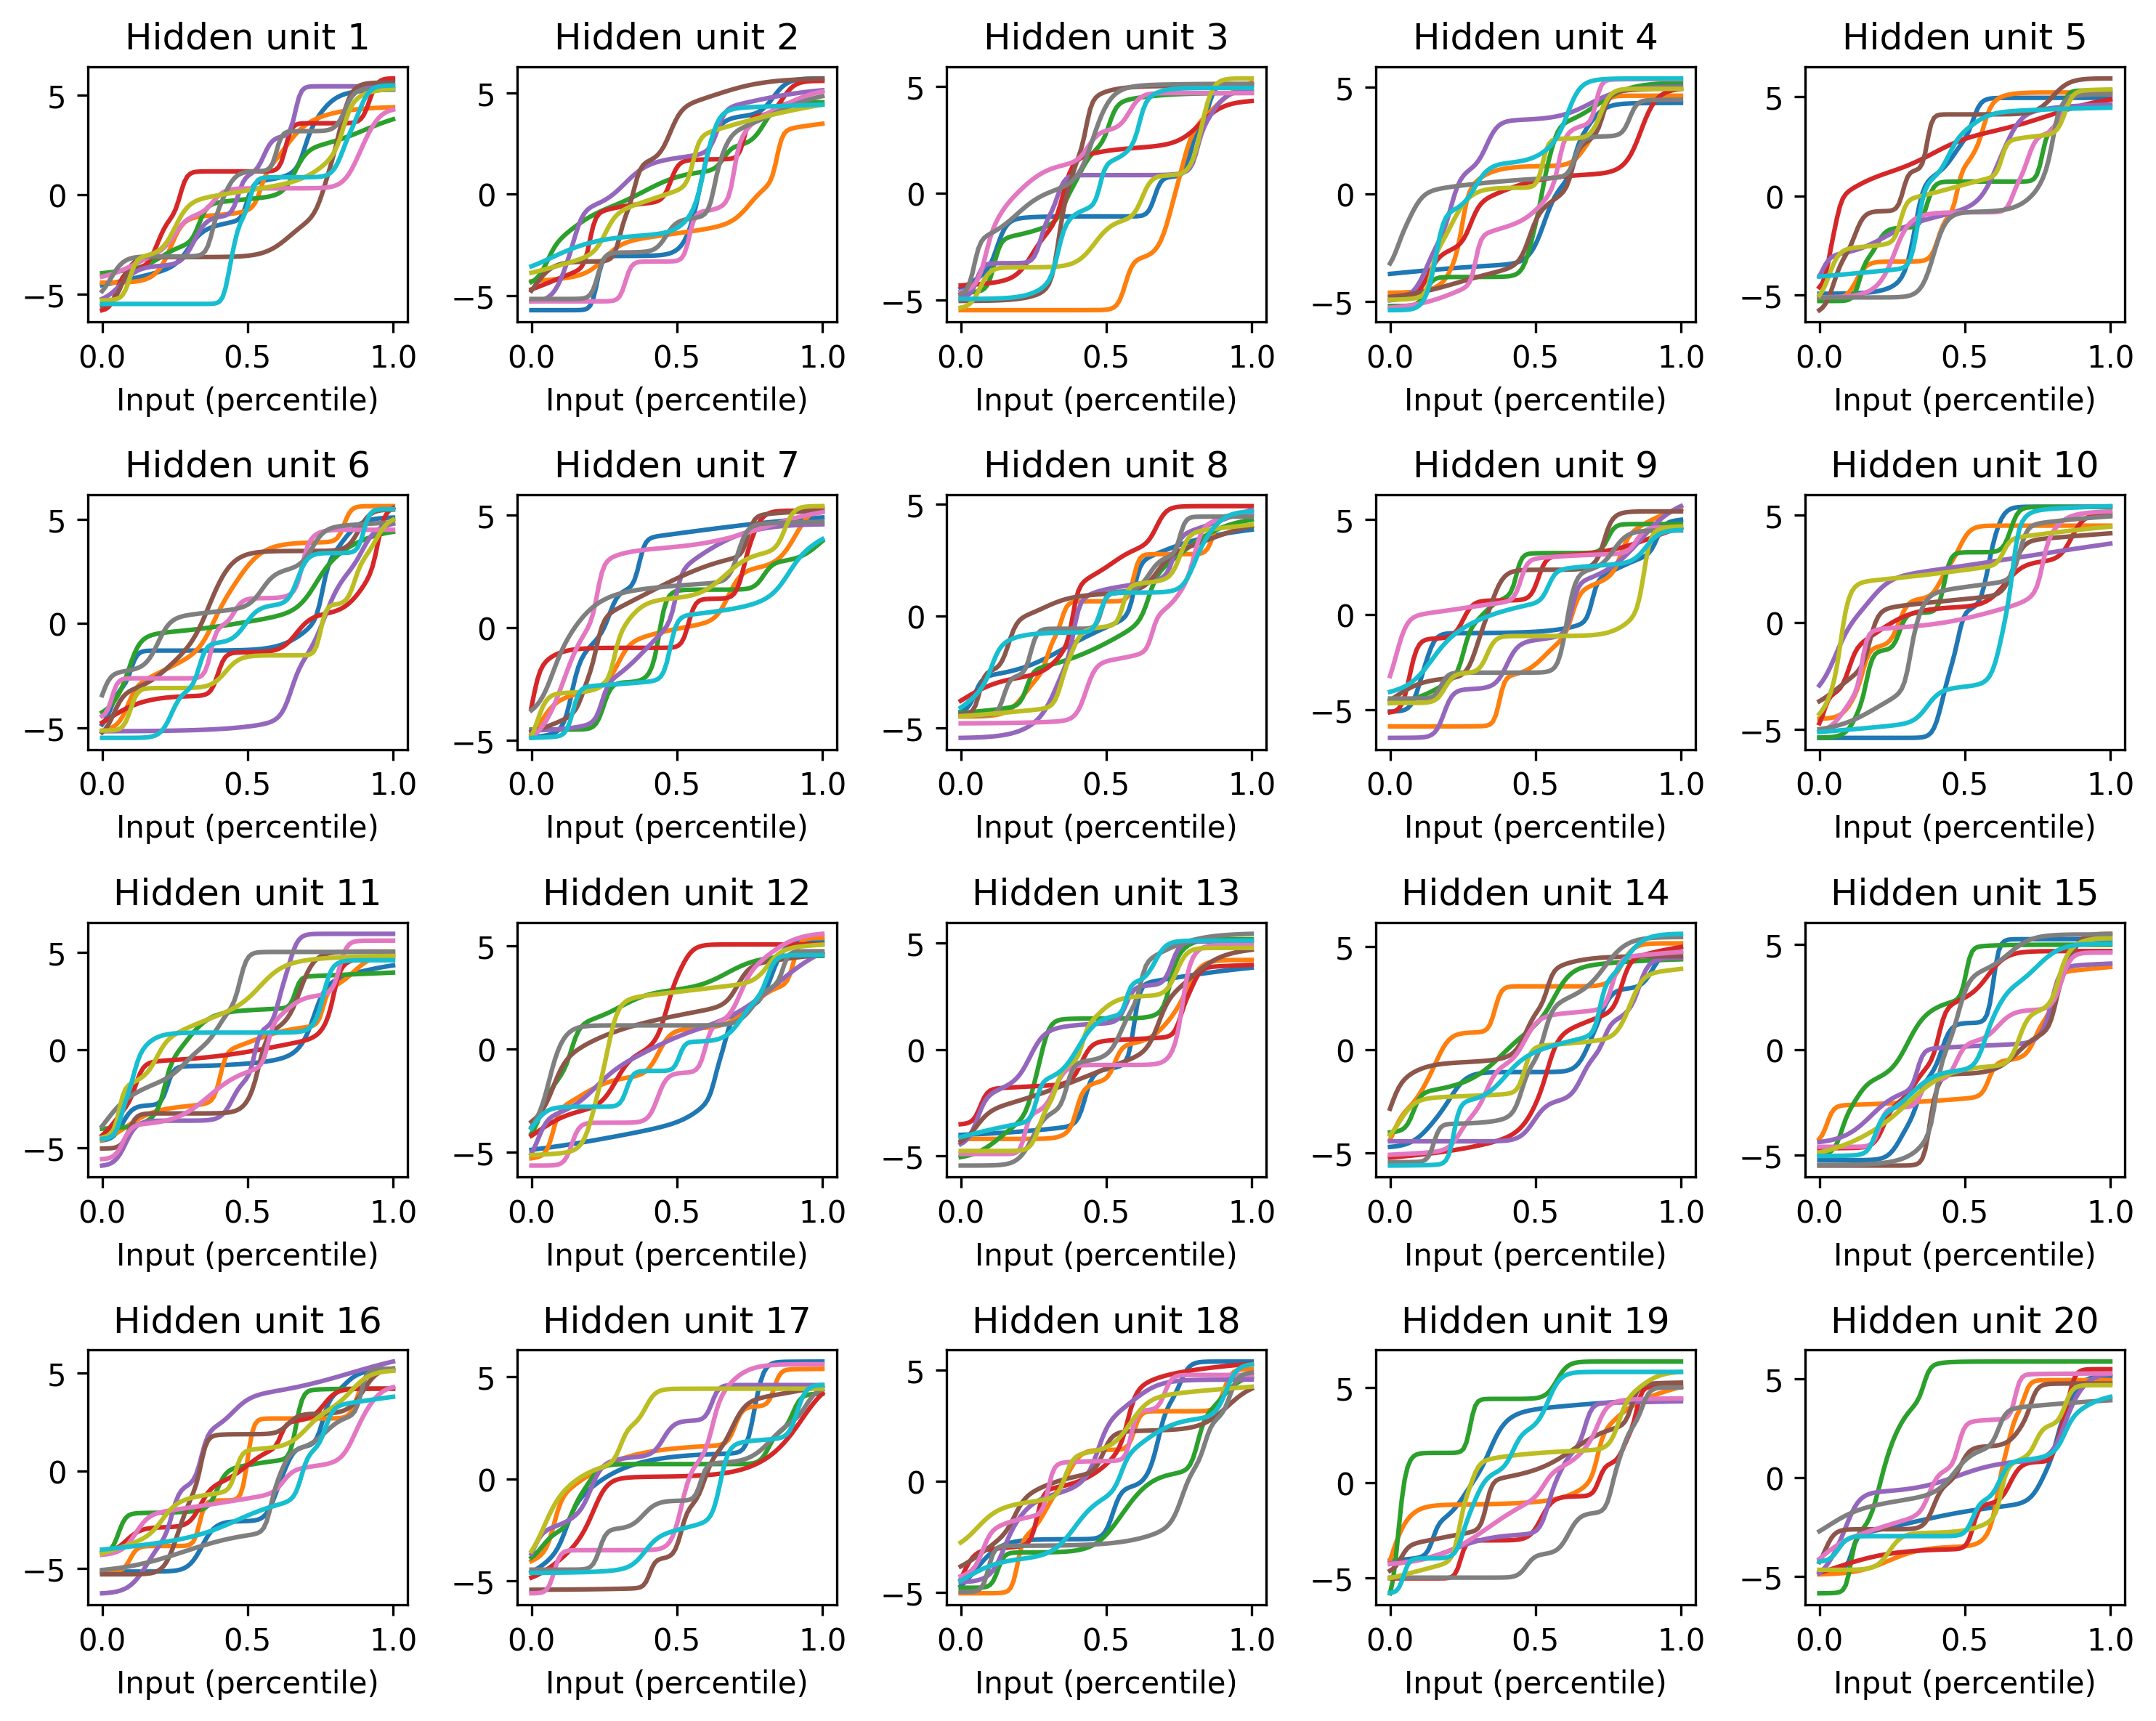

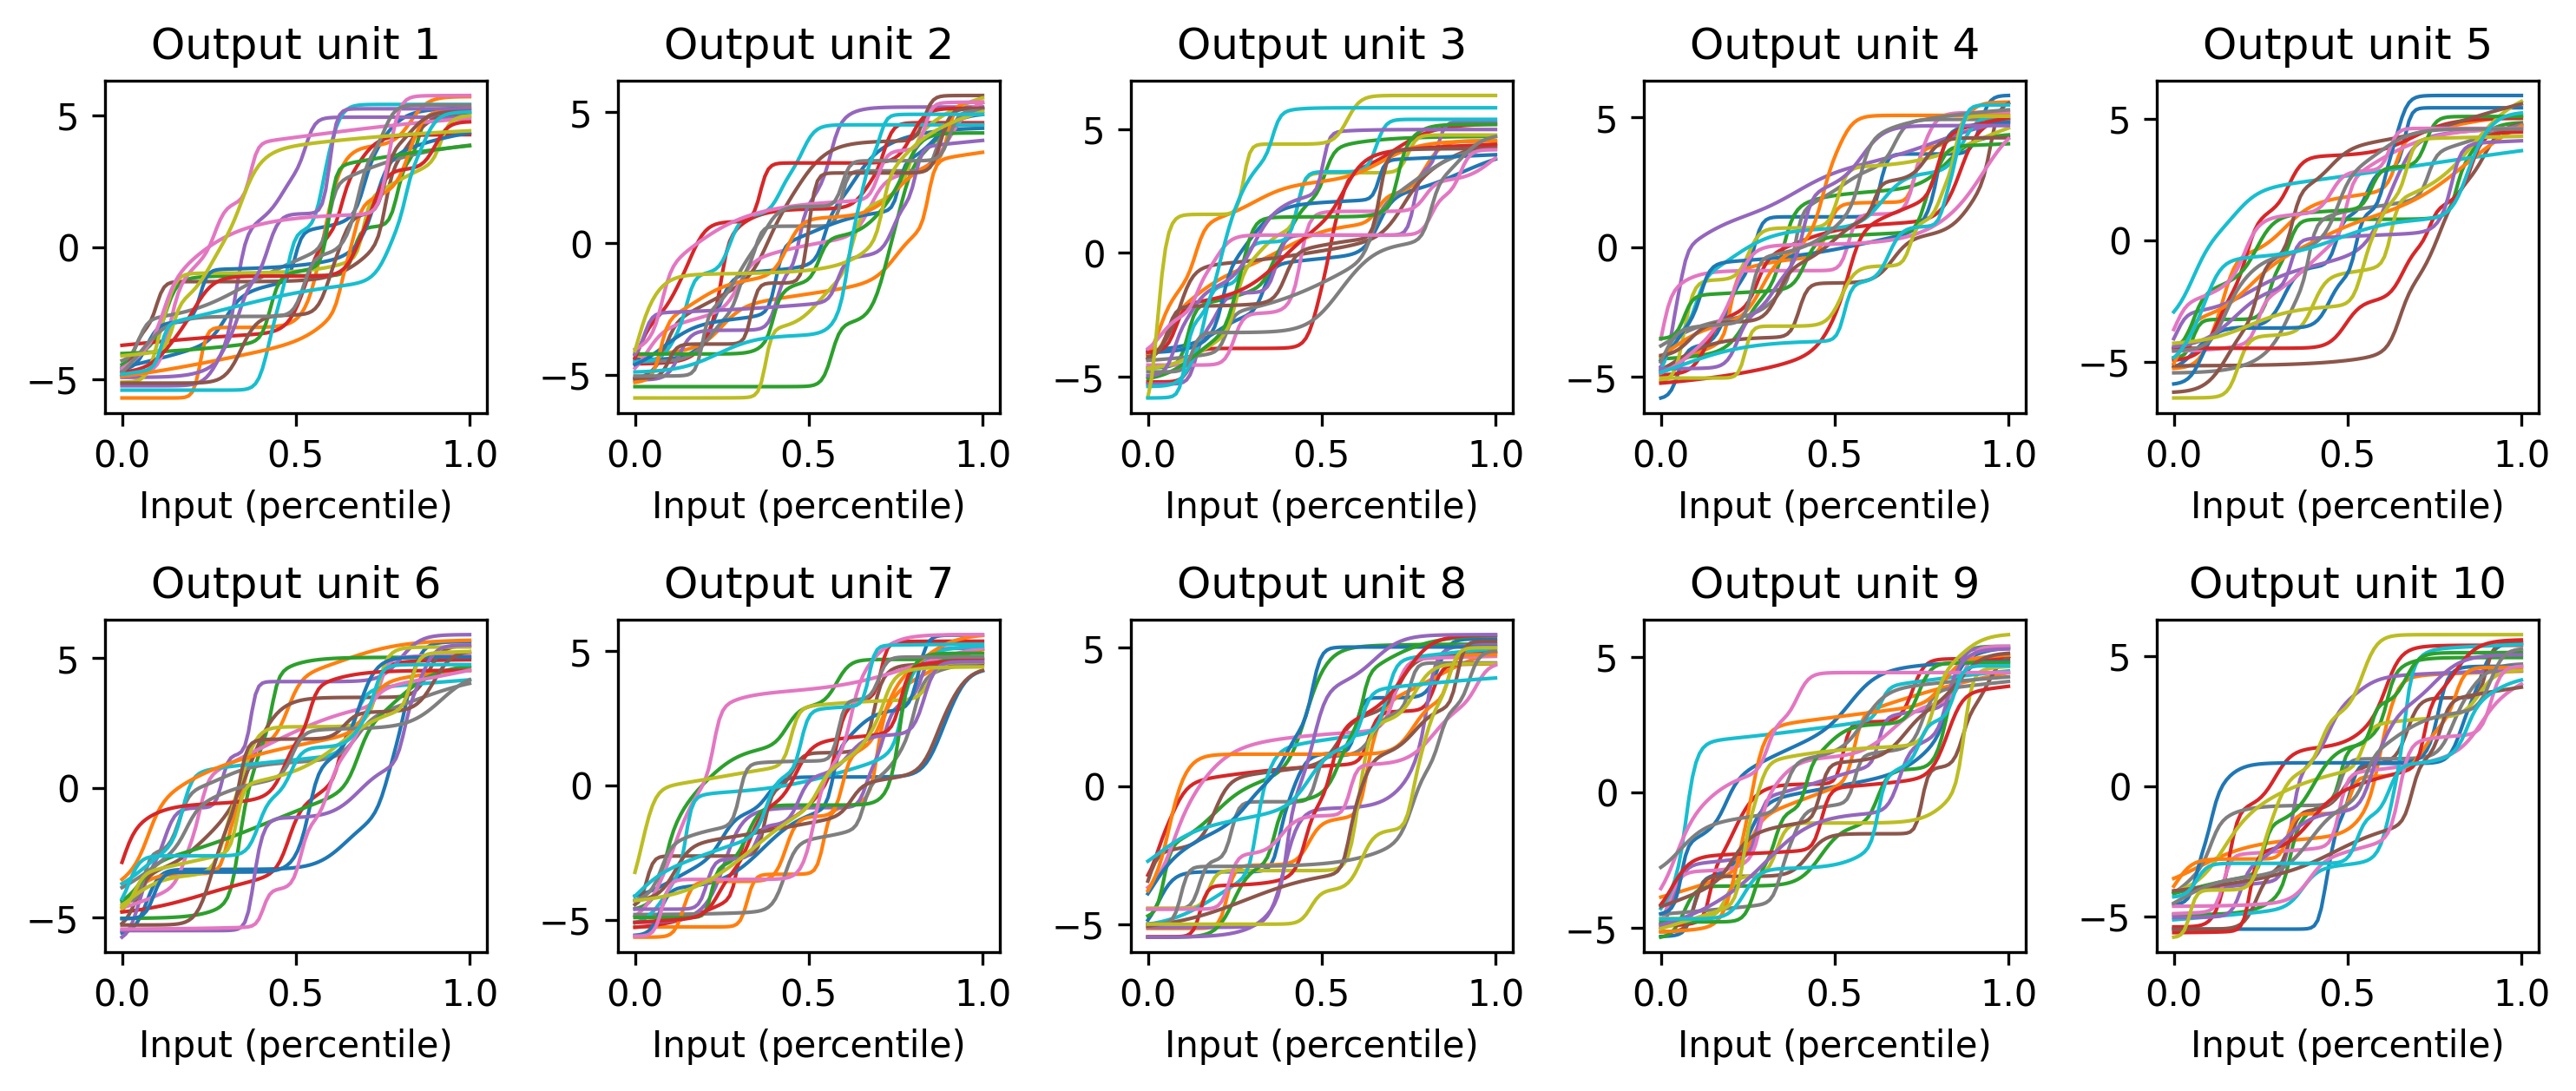

In [2]:
plot_parallel_synapse_params(model)

hidden = plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu', 
            file_name = '') 